In [110]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

In [111]:
# Functions

def PSI(P, q):
    return q[0]*P**2 + q[1]*P**4 + q[2]*P**6

def dy_da_1(P):
    return P**3 / 3

def dy_da_11(P):
    return P**5 /5

def dy_da_111(P):
    return P**7 / 7

def y(q):
    # analytical solution to PSI
    return (q[0]/3)*0.8**3 + (q[1]/5)*0.8**5 + (q[2]/7)*0.8**7

def y_trunc(q):
    # truncated solution to PSI
    return (q[0]/3)*0.8**3 + (q[1]/5)*0.8**5

def morris_screen(function, iterations, step_size, q, var_index):
    # function to evaluate step size
    # number of iterations to samples the space from
    # step_size of difference
    assert var_index >= 0 and var_index <= len(q), "variable index not within range of q"
    
    def randomizer(var_array):  # produces random inputs
        q = np.zeros(len(var_array))
        
        for i in range(len(var_array)):  # generate random inputs 
            q[i] = var_array[i]*0.8 + (var_array[i]*1.2-var_array[i]*0.8)*np.random.uniform(0,1)
            
        return q

    d_i = np.zeros(iterations)

#     for i in range(len(q)):  # generate random inputs 
#         q_random[i] = q[i]*0.8 + (q[i]*1.2-q[i]*0.8)*np.random.uniform(0,1)

    for i in range(iterations):
        q_random = randomizer(q)  # return randomizes q variable
        q_random_step = np.copy(q_random)  # copy to form forward finite diff
        q_random_step[var_index] += step_size  # add step size only for the specific variable of interest
    
        d_i[i] = (function(q_random_step) - function(q_random)) / step_size
#         print(function(q_random_step), function(q_random), d_i[i])

    u_i_star = (1 / iterations)*np.sum(np.abs(d_i))
    var_i = 1 / (iterations - 1) * np.sum( (d_i - u_i_star)**2)
    return d_i, u_i_star, var_i

def sobol_calc(A, B, C, D, func, var_idx):
    M = A.shape[0]
    y_A = np.zeros(M)
    y_B = np.zeros(M)
    y_Ci = np.zeros(M)
    y_D = np.zeros(2*M)
    
    C_i = np.copy(C)  # make copy of C
    C_i[:,var_idx] = B[:, var_idx]  # modify copied version of C, retains original C
    
    for k in range(M):
        y_A[k] = func(A[k, :])
        y_B[k] = func(B[k, :])
        y_Ci[k] = func(C_i[k, :])
    
    for k in range(2*M):
         y_D[k] = func(D[k, :])
            
    num_si = (1/M)*((np.dot(np.transpose(y_B), y_Ci)) - (np.dot(np.transpose(y_B), y_A)))
    
    expected_yD = np.mean(y_D)
    denominator =  ((1/(2*M))*np.dot(np.transpose(y_D), y_D)  - expected_yD**2) 
#    
 
#     print(expected_yD - (1/(2*M))*np.sum(y_D))
    
    S_i = num_si / denominator
    
    num_s_ti = (1 / (2*M))*(np.dot(np.transpose(y_A), y_A) - 2*np.dot(np.transpose(y_A), y_Ci) + np.dot(np.transpose(y_Ci), y_Ci)) 
    
    S_T_i = num_s_ti / denominator
    return S_i, S_T_i, y_A
    


### (a)
Plot The energy for P on interval [-0.8, 0.8]

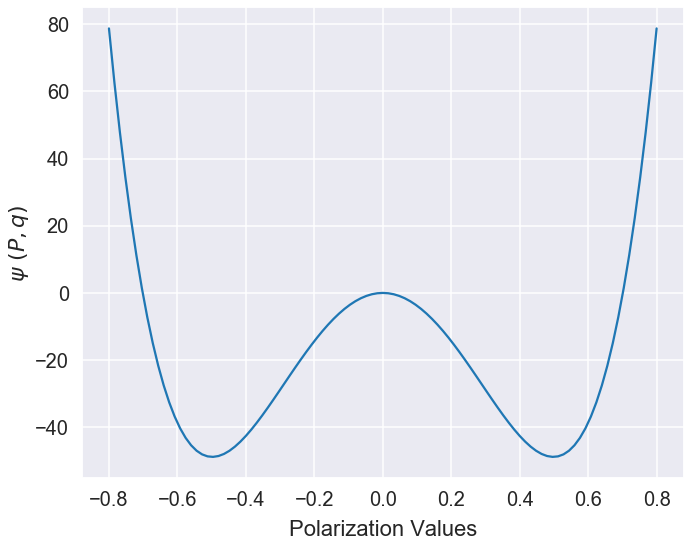

In [112]:
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

a_1, a_11, a_111 = -389.4, 761.3, 61.5
q = [a_1, a_11, a_111]
p_interval = np.linspace(-0.8, 0.8, 101)

fig, axe = plt.subplots(ncols=1, nrows=1, figsize=(10,8))
axe=sns.lineplot(p_interval, PSI(p_interval, q))
axe.set_xlabel('Polarization Values', labelpad=10);
axe.set_ylabel('$\psi \ (P,q)$');
plt.tight_layout()
plt.savefig('problem3_a.png')

### (b) 
Compute Sensitivity Matrix $\chi$ using 17 equally spaced polarization values in the domain [0, 0.8]. Compute the rank of V and discuss the identifiability of the parameters

In [113]:
p_domain = np.linspace(0, 0.8, 17)

# Chi is partial of  ∂ y(x_i, q) / q_j  how response changes at various independent inputs with respect to parameter

Chi = np.column_stack((dy_da_1(p_domain),dy_da_11(p_domain), dy_da_111(p_domain)))
rank = np.linalg.matrix_rank(np.transpose(Chi)@Chi)
r = 50
delta = 1 /20

print('Matrix Rank:', rank)

alpha_1_morris = morris_screen(y, r, delta, q, 0)
alpha_11_morris = morris_screen(y, r, delta, q, 1)
alpha_111_morris = morris_screen(y, r, delta, q, 2)

grad_alphas = Chi[-1, :]
u_star = [alpha_1_morris[1], alpha_11_morris[1], alpha_111_morris[1]]

print('Morris Method: ', u_star, '\n', 'Analytic', grad_alphas)
grad_alphas-u_star

Matrix Rank: 3
Morris Method:  [0.1706666666667047, 0.0655359999999348, 0.02995931428571197] 
 Analytic [0.17066667 0.065536   0.02995931]


array([-3.79973830e-14,  6.52117249e-14,  2.32799890e-15])

### (C)
Analytical Sobol sensitivity indices

## Coefficients $C_i $ for $\theta_i$: $ \frac{1}{(2n +1)}(0.8)^{2n+1} : n={\{1,2,3}\} $
## Variance for the $i^{th}$ parameter:  $\sigma_i^2=\frac{(b_i - a_i)^2}{12}$
## Partial Variances $D_i = C_1^2 \sigma_i^2$
## Sobal Indices $S_i = \frac{D_i}{D}$

In [114]:
c_i = [(1/3)*0.8**3, (1/5)*0.8**5, (1/7)*0.8**7]
variance_i = [(q[i]*1.2 - q[i]*0.8)**2 / 12 for i in range(3)]
D_i = [variance_i[n]*c_i[n]**2 for n in range(3)]
D = sum(D_i)

S_i = [D_i[n]/D for n in range(3)]
print(S_i)
sum(S_i)

[0.6392295632516554, 0.36027909743488923, 0.0004913393134554694]


1.0000000000000002

Approximating the sensitivity indices

In [115]:
q_range = [[q[k]*0.8, q[k]*1.2,] for k in range(3)]
q_range[0] = list(reversed(q_range[0]))
M = int(10e5)
a, b=[np.random.uniform(q_range[k][0], q_range[k][1],M) for k in range(3)], [np.random.uniform(q_range[k][0], q_range[k][1],M) for k in range(3)]
A, B = np.transpose(np.asarray(a)), np.transpose(np.asarray(b))
C = np.copy(A)

D = np.row_stack((A,B))

In [116]:
S_numerical_all = [sobol_calc(A, B, C, D, y, i) for i in range(3)]
# first index of tuple is S_i , second index of tuple is S_Ti 

In [117]:
S_numerical_influential = [sobol_calc(A[:,0:2], B[:,0:2], C[:,0:2], D[:,0:2], y_trunc, i) for i in range(2)]
# first index of tuple is S_i , second index of tuple is S_Ti  
# REMOVED a_111

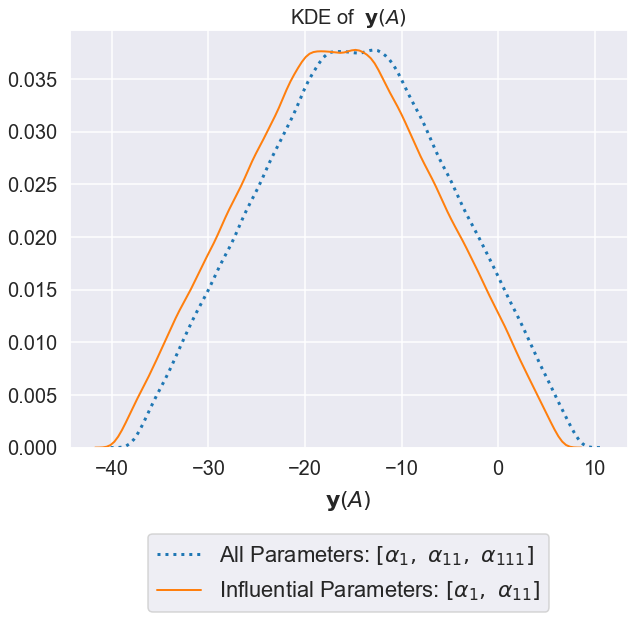

In [118]:
# KDE Plot for 2 variables a_1, a_11 : Influential Only
# KDE Plot for 3 variables a_1, a_11, and a_111
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10, 10))
sns.kdeplot(S_numerical_all[0][-1], label='All Parameters:' + r' $[\alpha_1 ,\ \alpha_{11} ,\ \alpha_{111}]$', linewidth=3, linestyle=':')
sns.kdeplot(S_numerical_influential[0][-1], label='Influential Parameters:' + r' $[\alpha_1 ,\ \alpha_{11}]$',linewidth=2)
axes.set_xlabel(r'$\bf{y}$' +'$(A)$', labelpad=10)
axes.set_title('KDE of' + r'  $\bf{y}$' +'$(A)$');
plt.legend(bbox_to_anchor=(+0.5, -0.30), loc='center', borderaxespad=0.)
# plt.tight_layout()
fig.subplots_adjust(bottom=0.30)
plt.savefig('KDE_Overlap.png')


In [119]:
s_total = [S_numerical_all[i][0] for i in range(3)]
print(s_total)

s_distinct = [S_numerical_influential[i][0] for i in range(2)]
print(s_distinct)


[0.6406454126385882, 0.3627365402405829, 0.0004919917336462766]
[0.6412432957738503, 0.36315354988141496]


In [124]:
# give_me_random_q = [[], [],[]]
# for i in range(len(q)):  # generate random inputs 
#             give_me_random_q[i] = q[i]*0.8 + (q[i]*1.2-q[i]*0.8)*np.random.uniform(0,1)
            
# give_me_random_q

A_matrix = np.array([[5, 0, 0, 0 ], [0, 5, 0, 0], [1, 4, -3, 0], [-1, -2, 0, -3]])

np.linalg.eig(A_matrix)

(array([-3., -3.,  5.,  5.]),
 array([[ 0.        ,  0.        ,  0.98473193,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.87287156],
        [ 1.        ,  0.        ,  0.12309149,  0.43643578],
        [ 0.        ,  1.        , -0.12309149, -0.21821789]]))